<a href="https://colab.research.google.com/github/bgohrani/Convolutional_Neural_Networks/blob/main/5.ML_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import time
import seaborn as sns
import torchvision.models as models
import copy
import torchvision
from torchvision.transforms import transforms
import mlflow
import mlflow.pytorch

#importing essential libraries

In [ ]:
class Params(object):
  
  def __init__(self,batch_size,epochs,seed,storing_int):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.interval = storing_int

args = Params(256,5,0,40)

#Creating an object for easy access and modification of parameters

In [ ]:
data_transform = torchvision.transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))                   
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=data_transform)
testset =  torchvision.datasets.MNIST(root='./data', train=False,download=True,transform=data_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = args.batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = args.batch_size, shuffle = False)

#Creating transformations for our data, and loading the MNIST dataset
#Creating dataloaders to load our images in batches
#args.size is used here for batch_size, incase we wished to change we can just change the code above

In [ ]:
class FF_network(nn.Module):

  def __init__(self, nH):
    super(FF_network,self).__init__()  #Check this 
    self.feedf = nn.Sequential(
        nn.Linear(784,nH),
        nn.ReLU(),
        nn.Linear(nH,10)
    )
  
  def forward(self,x):
    x1 = x.view(x.shape[0],-1)
    x2 = self.feedf(x1)

    return x2

#Creating a simple FeedForward Neural network for training with two linear layers

In [ ]:
def train(epoch):
  print('Epoch:',epoch)
  print('Learning Rate:',lr,'   Momentum:',moment,'    Hidden_layer_val:',hidden_values)
  model.train()
  for i, data in enumerate(trainloader,0):

    inputs, labels = data
    opt.zero_grad()
    output = model(inputs)
    loss_train = loss_func(output,labels)
    loss_train.backward()
    opt.step()

    if i % args.interval == 0:
      mlflow.log_metric("Training Loss",loss_train.item())
      print('Training Loss is:', loss_train.item())

#Training loop similar to ones written earlier
#We loop through all the batches, do the forward pass, loss calculation, backpropagation and optimization
#Once every interval, we log training loss in mlflow and print it

In [ ]:
def test(epoch):

  print('Test on Epoch:', epoch)
  model.eval()
  accuracy_count = 0
  total = 0
  total_loss = 0
  for data in testloader:
    inputs, labels = data
    output = model(inputs)
    loss_test = loss_func(output,labels)
    total_loss += loss_test.item()
    total += labels.size(0)
    max_values1,max_classes1 = torch.max(output, axis=1)
    accuracy_count += (labels == max_classes1).sum().item()

  computed_accuracy = (accuracy_count/total)*100
  mlflow.log_metric('Test_loss', total_loss/len(inputs))
  mlflow.log_metric('Test_accuracy', computed_accuracy)
  print('Calculated Accuracy:',computed_accuracy)
  print('Calculated Loss:', total_loss)
  
#Calculating the accuracy as usual and logging the value in MLFlow

In [ ]:
# mlflow.create_experiment('visualize1')
mlflow.set_experiment('visualize1')

for lr in [0.05]:
  for moment in [0.9]:
    for hidden_values in [48]:

      model = FF_network(hidden_values)
      opt = optim.SGD(model.parameters(),lr=lr,momentum=moment)
      loss_func = nn.CrossEntropyLoss()

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key,value)
        
        mlflow.log_param('Lr',lr)
        mlflow.log_param('Momentum',moment)
        mlflow.log_param('hidden_layer',hidden_values)

        for epoch in range(1, args.epochs + 1):
          train(epoch)
          test(epoch)

          if epoch == args.epochs:
            output_pred = []
            total_labels = []
            model.eval()
            for data in testloader:
              inputs, labels = data
              output = model(inputs)
              total_labels += labels.tolist()
              max_values1,max_classes1 = torch.max(output, axis=1)
              output_pred += max_classes1.tolist()

            confusion_matrix = np.zeros([10,10]).astype(int)
            output_pred = torch.tensor(output_pred)
            total_labels = torch.tensor(total_labels)
            conf_construct = torch.transpose(torch.stack((output_pred,total_labels)),1,0)

            for point in conf_construct:
              a = point[0].item()
              b = point[1].item()
              confusion_matrix[a][b] += 1

            plt.figure(dpi=200)
            cmap = sns.cm.rocket_r
            ax = sns.heatmap(confusion_matrix,cmap="YlGnBu",annot=True,annot_kws={"fontsize":6},fmt='d')
            ax.xaxis.set_ticks_position('top')
            plt.xlabel('True Values')
            plt.ylabel('Pred Values')
            plt.title('Confusion Matrix') 
            imagepath = '%s_%s_%s.png' %(lr,moment,hidden_values)
            plt.savefig(imagepath)
            mlflow.log_artifact(imagepath)
            plt.close()

          mlflow.pytorch.log_model(model,'Model')

#Creating an experiment in MLFlow, we set the name to visualize1 
#We then create loops of learning rates, momentum, and hidden layers, these can contain multiple values
#Inside the loops we instantiate our class, set the criterion and optimizer 
#We then log all the parameters in our params object into MLFlow 
#We then log all the parameters we have given in the loops above, these can change
#We then loop through all the epochs and call the training and test functions
#If all the epochs are complete, we put the model into eval mode and make it predict on the whole test data
#Once we do that, we take the predicted values and the ground truths to plot a confusion matrix
#We can then plot the confusion matrix using a heatmap from seaborn
#This can also be saved with the help of MLFlow
#After each epoch we can also save the model at that state to load later

Epoch: 1
Learning Rate: 0.05    Momentum: 0.9     Hidden_layer_val: 48
Training Loss is: 2.2916576862335205
Training Loss is: 0.4466315507888794
Training Loss is: 0.27898022532463074
Training Loss is: 0.22063137590885162
Training Loss is: 0.17102019488811493
Training Loss is: 0.17749449610710144
Test on Epoch: 1
Calculated Accuracy: 95.19999999999999
Calculated Loss: 6.129959790967405
Epoch: 2
Learning Rate: 0.05    Momentum: 0.9     Hidden_layer_val: 48
Training Loss is: 0.24051004648208618
Training Loss is: 0.11272548139095306
Training Loss is: 0.12951412796974182
Training Loss is: 0.07024864107370377
Training Loss is: 0.04422441124916077
Training Loss is: 0.10907804220914841
Test on Epoch: 2
Calculated Accuracy: 96.53
Calculated Loss: 4.405067229177803
Epoch: 3
Learning Rate: 0.05    Momentum: 0.9     Hidden_layer_val: 48
Training Loss is: 0.07602490484714508
Training Loss is: 0.1315661072731018
Training Loss is: 0.08469649404287338
Training Loss is: 0.17128609120845795
Training Los

In [ ]:
output_pred = []
total_labels = []
model.eval()
for data in testloader:
  inputs, labels = data
  output = model(inputs)
  total_labels += labels.tolist()
  max_values1,max_classes1 = torch.max(output, axis=1)
  output_pred += max_classes1.tolist()

confusion_matrix = np.zeros([10,10]).astype(int)
output_pred = torch.tensor(output_pred)
total_labels = torch.tensor(total_labels)
conf_construct = torch.transpose(torch.stack((output_pred,total_labels)),1,0)

for point in conf_construct:
  a = point[0].item()
  b = point[1].item()
  confusion_matrix[a][b] += 1

#Raw code for creating the confusion matrix as explained earlier

In [ ]:
confusion_matrix

array([[ 953,    0,    1,    1,    1,    2,    5,    1,    3,    2],
       [   0, 1123,    0,    2,    0,    1,    3,    5,    1,    4],
       [   4,    4, 1007,   10,    3,    0,    1,   13,    4,    0],
       [   2,    1,    4,  977,    0,   18,    1,    5,    7,    5],
       [   1,    0,    8,    0,  957,    2,    8,    1,    7,   13],
       [   3,    1,    0,    3,    1,  850,    2,    1,    3,    5],
       [   7,    2,    5,    0,    3,    8,  937,    0,    6,    1],
       [   1,    1,    3,    8,    2,    0,    0,  987,    5,    4],
       [   3,    3,    2,    5,    1,    6,    1,    1,  929,    3],
       [   6,    0,    2,    4,   14,    5,    0,   14,    9,  972]])

Text(0.5, 1.0, 'Confusion Matrix')

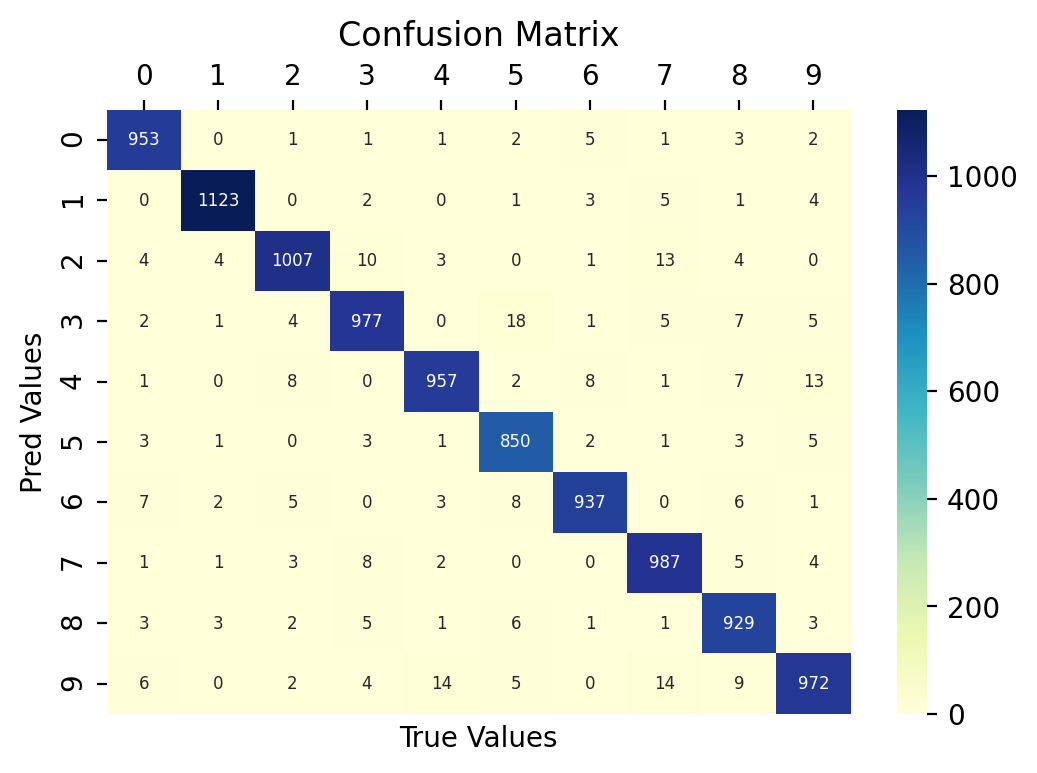

In [ ]:
plt.figure(dpi=200)
cmap = sns.cm.rocket_r
ax = sns.heatmap(confusion_matrix,cmap="YlGnBu",annot=True,annot_kws={"fontsize":6},fmt='d')
ax.xaxis.set_ticks_position('top')
plt.xlabel('True Values')
plt.ylabel('Pred Values')
plt.title('Confusion Matrix')

#Raw code for plotting and visualizing the confusion matrix, this is how it would look like
#The ideal confusion matrix must be a diagonal one

In [ ]:
model = mlflow.pytorch.load_model('file:///mnt/c/Users/Bharath%20Gohrani/Desktop/mlruns/8/1ee460abb4f044ec87f23eef8844db53/artifacts/Model')
print(model)
weights_0 = list(model.parameters())[0]
print(weights_0.shape)

#We can load a saved model from MLFlow with the following code 

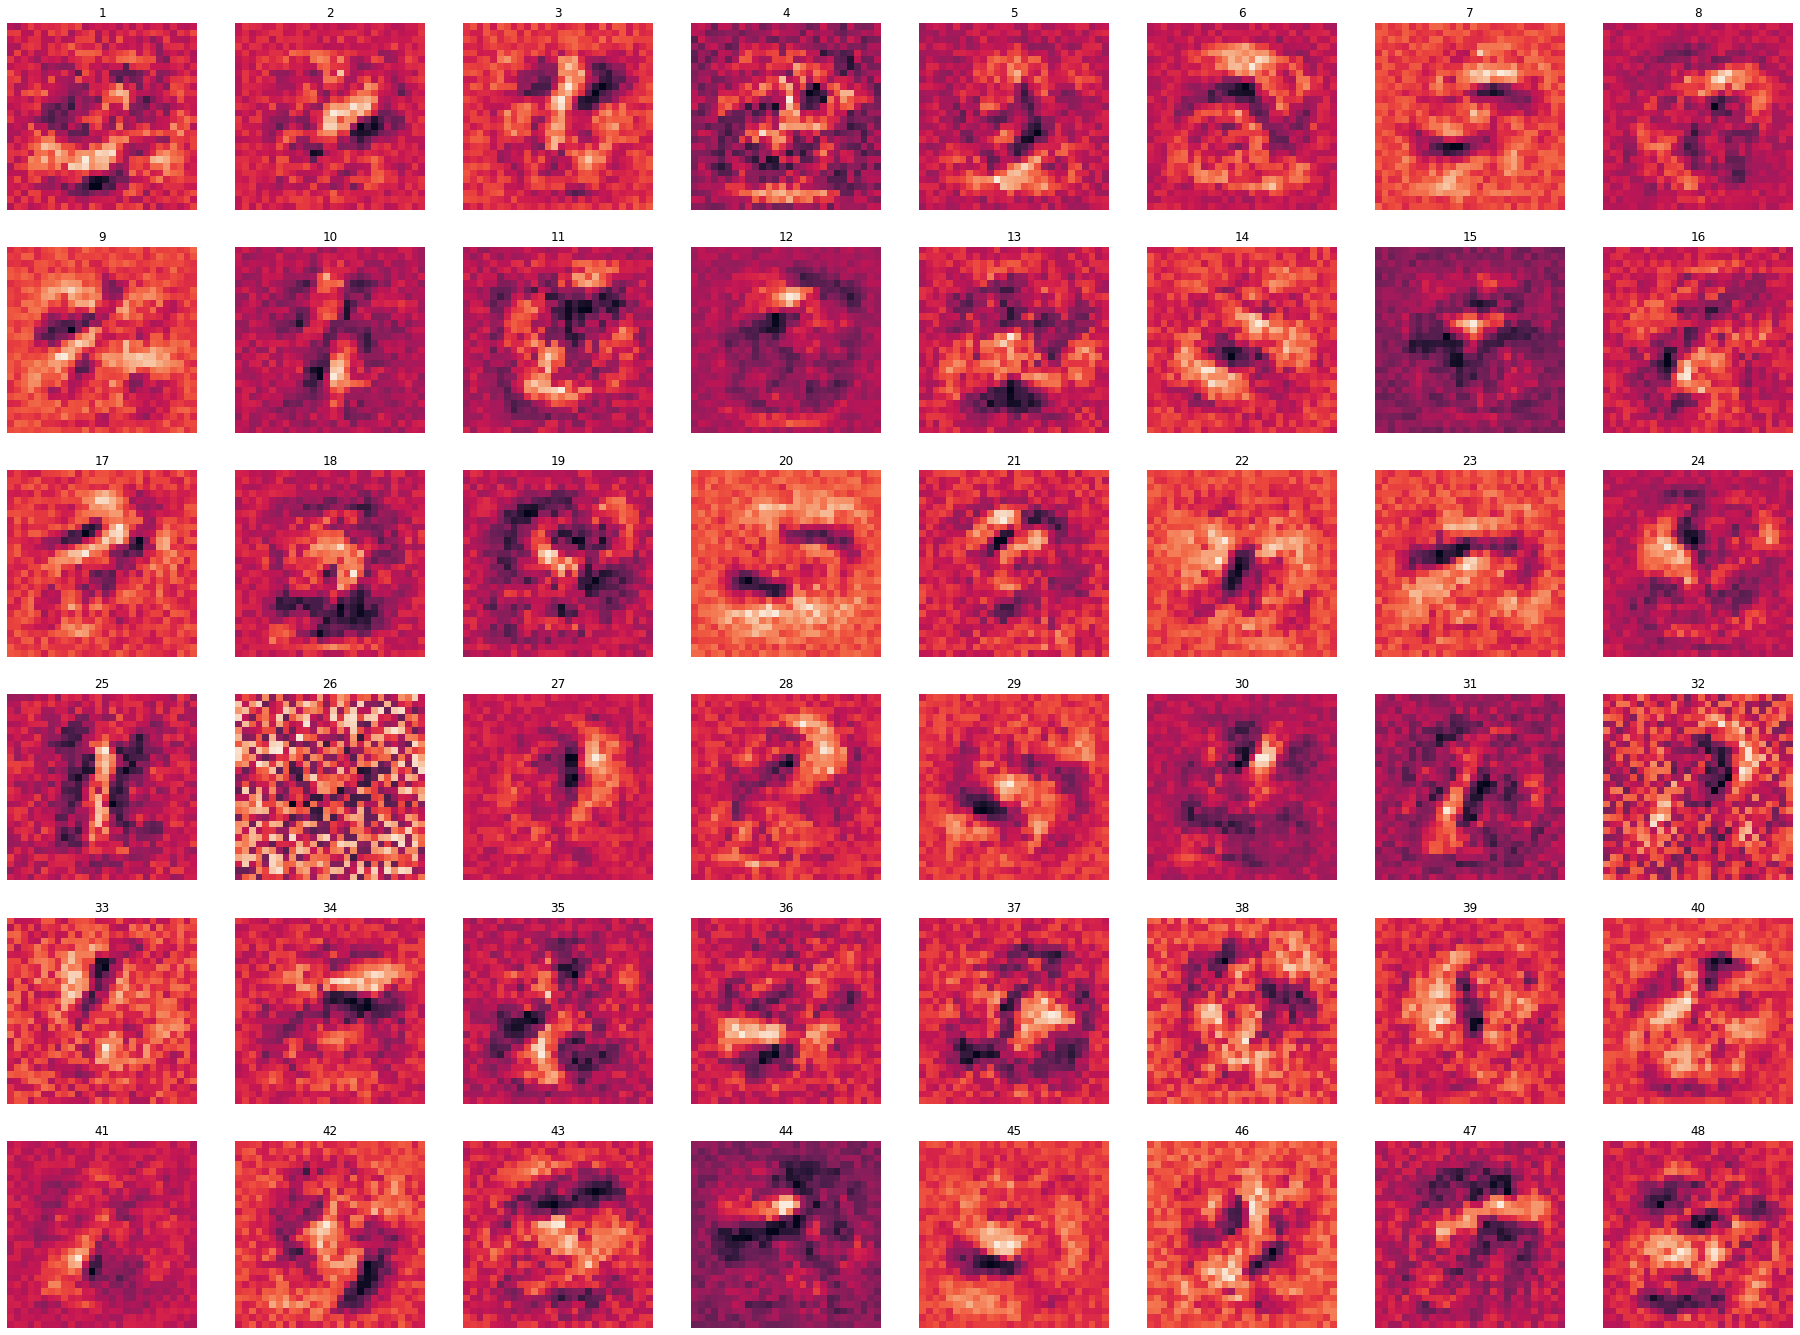

In [ ]:
fig, axs = plt.subplots(6,8,figsize= (32,24))
for i in range(48):
  ax = plt.subplot(6,8,i+1)
  plt.axis('off')
  plt.title(str(i+1))
  ax = sns.heatmap(weights_0[i].reshape(28,28).detach().numpy(),cbar = False)

#If we take the first linear layer, we have 784x48 parameters or 28x28x48 parameters 
#We plot each 28x28 parameter as a heatmap which can be seen as images below